# RNN

In [1]:
#Importing everything needed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
#Created a class which a produces a sine wave as data
class TimeSeriesData():
    
    def __init__(self, num_points, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
    
    #Y true values
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    #Get next batch
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        
        rand_start = np.random.rand(batch_size,1)
        
        ts_start = rand_start * (self.xmax - self.xmin - (steps * self.resolution))
        
        batch_ts = ts_start + np.arange(0.0, steps+1) * self.resolution
        
        y_batch = np.sin(batch_ts)
        
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:,1:].reshape(-1, steps, 1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:,1:].reshape(-1, steps, 1)

In [3]:
#Create a data with 250 point from 0 to 10
ts_data = TimeSeriesData(250, 0, 10)

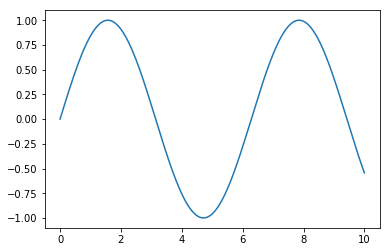

In [4]:
#Plot the data
plt.plot(ts_data.x_data, ts_data.y_true)

In [5]:
#Number of steps
num_time_steps = 30

In [6]:
#Get the nest batch, ts being x and ys being the wave
y1, y2, ts = ts_data.next_batch(1, num_time_steps, True)

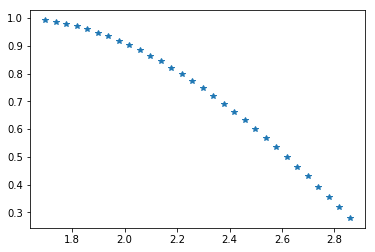

In [7]:
#Plot the batch
plt.plot(ts.flatten()[1:], y2.flatten(), '*')

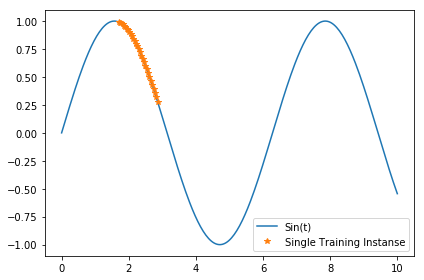

In [8]:
#Visualize the data
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', label='Single Training Instanse')
plt.legend()
plt.tight_layout()

In [9]:
train_inst = np.linspace(5, 5 + ts_data.resolution*(num_time_steps+1), num_time_steps+1)

In [10]:
train_inst

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

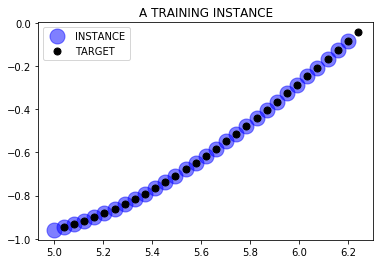

In [11]:
plt.title('A TRAINING INSTANCE')

plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='INSTANCE')

plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), 'ko', markersize=7, label='TARGET')

plt.legend()

# Creating the Model

In [12]:
tf.reset_default_graph()

In [13]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.0001
num_train_iterations = 2000
batch_size = 1

In [14]:
x = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [15]:
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu), 
                                              output_size=num_outputs)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [16]:
outputs, states = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [17]:
loss = tf.reduce_mean(tf.square(outputs-1))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [18]:
init = tf.global_variables_initializer()

In [19]:
saver = tf.train.Saver()

In [20]:
with tf.Session() as sess:
    
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        x_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        
        sess.run(train, feed_dict = {x:x_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={x:x_batch, y:y_batch})
            print(iteration, "\t MSE", mse)
        
        saver.save(sess, './sine_model')

0 	 MSE 1.0260527
100 	 MSE 0.5947926
200 	 MSE 0.15326646
300 	 MSE 0.14124082
400 	 MSE 0.035759132
500 	 MSE 0.041592
600 	 MSE 0.03883306
700 	 MSE 0.028045006
800 	 MSE 0.035635956
900 	 MSE 0.02261195
1000 	 MSE 0.023410294
1100 	 MSE 0.030605055
1200 	 MSE 0.01838259
1300 	 MSE 0.015885996
1400 	 MSE 0.025690774
1500 	 MSE 0.025262564
1600 	 MSE 0.01521346
1700 	 MSE 0.0154659515
1800 	 MSE 0.010956335
1900 	 MSE 0.010096296


In [21]:
with tf.Session() as sess:
    
    saver.restore(sess, './sine_model')
    
    x_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    
    y_pred = sess.run(outputs, feed_dict={x: x_new})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./sine_model


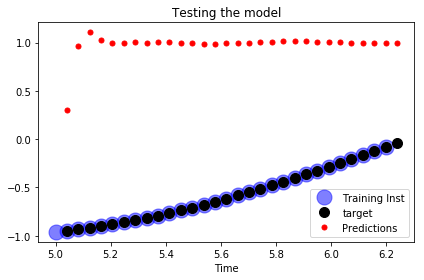

In [22]:
plt.title("Testing the model")

plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='Training Inst')

plt.plot(train_inst[1:], np.sin(train_inst[1:]), 'ko', markersize=10, label='target')

plt.plot(train_inst[1:], y_pred[0,:,0], 'r.', markersize=10, label='Predictions')

plt.xlabel('Time')
plt.legend()
plt.tight_layout()